# Data splitting

In [168]:
from typing import Optional, Tuple, List, Iterator

import pandas as pd
import numpy as np

In [169]:
def generate_cv_data(df: pd.DataFrame, n_folds: int = 5, random_state: Optional[int] = None
                     ) -> Iterator[Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Generates train and test datasets for cross-validation.
    Parameters:
    - df: pandas DataFrame, input DataFrame to be divided.
    - n_folds: int, number of folds to generate.
    - random_state: int, random seed to be set allowing for reproducibility of results.
    """
    if random_state is not None: np.random.seed(random_state)
    idx = np.random.permutation(df.index)
    n = len(df)
    for i in range(n_folds):
        mask = np.zeros(n, dtype=bool)
        mask[i::n_folds] = True
        df_train = df.loc[idx[~mask]]
        df_test = df.loc[idx[mask]]
        yield df_train, df_test

In [170]:
def split_data(df, test_size: float, random_state: Optional[int]
               ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Function to split a DataFrame into training and testing sets.

    Parameters:
    - df: DataFrame object containing all the data
    - test_size: proportion of data to be allocated to the test set
    - random_state: value used to initialize the random number generator

    Returns:
    - df_train: DataFrame containing the training set
    - df_test: DataFrame containing the testing set
    """
    np.random.seed(random_state)

    indices = df.index.values.copy()
    np.random.shuffle(indices)

    test_size = int(len(df) * test_size)

    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    df_train = df.loc[train_indices]
    df_test = df.loc[test_indices]

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_test

# Preprocessing

In [171]:
def remove_single_value_columns(df_train: pd.DataFrame, 
                                df_test: pd.DataFrame, 
                                target_column: str,
                                frac_threshold: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove columns with single value 

    Parameters:
    - df_train: pandas DataFrame, input DataFrame containing features.
    - df_test: pandas DataFrame, input DataFrame containing features.
    - target_column: str, name of the target column.
    - frac_threshold: if a fraction of some value in a column is higher than the specified
        threshold, we consider it a single value column (it might have more than 1 value, but
        there is a risk that it will change after cv splits)

    Returns:
    - pandas DataFrame, DataFrame with one value features removed.
    - pandas DataFrame, DataFrame with one value features removed based on train 
    """
    x_train = df_train.drop(columns=[target_column])
    single_value_columns = []

    for col in x_train.columns:
        values_fractions = x_train[col].value_counts() / len(x_train[col])
        # if [no values] or [condition for single value col met]:
        if len(values_fractions) == 0 or np.any(values_fractions > frac_threshold):
            single_value_columns.append(col)

    # single_value_columns = [col for col in x_train.columns if x_train[col].nunique() <= 1]

    df_without_single_value_columns_train = df_train.drop(single_value_columns, axis=1)
    df_without_single_value_columns_test = df_test.drop(single_value_columns, axis=1)

    return df_without_single_value_columns_train,  df_without_single_value_columns_test

In [172]:
def remove_highly_correlated(df: pd.DataFrame, target_column: str, 
                             threshold: float, method: str) -> List[str]:
    """
    Remove one of two features that are highly correlated above the threshold.

    Parameters:
    - df: pandas DataFrame, input DataFrame containing features.
    - target_column: str, name of the target column.
    - threshold: float, correlation threshold.
    - method: str, method of correlation calculation: 'pearson' or 'spearman'.

    Returns:
    - list of strings, names of columns to be removed.
    """
    features_df = df.drop(columns=[target_column])

    if method == 'pearson':
        corr_matrix = features_df.corr(method='pearson').abs()
    elif method == 'spearman':
        corr_matrix = features_df.corr(method='spearman').abs()
    else:
        raise ValueError("Invalid method. Please choose 'pearson' or 'spearman'.")

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_with_mask = corr_matrix.mask(mask)
    to_drop = [column for column in corr_matrix_with_mask.columns 
               if any(corr_matrix_with_mask[column] > threshold)]

    #if we would like to change for df
    #features_filtered = features_df.drop(columns=to_drop)
    #df_filtered = pd.concat([features_filtered, df[target_column]], axis=1)

    return to_drop

In [173]:
def min_max_scaler(df_train: pd.DataFrame, df_test: pd.DataFrame, 
                   target_column: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Applies Min-Max scaling to the training and testing sets.

    Parameters:
    - df_train: pandas DataFrame, training set.
    - df_test: pandas DataFrame, testing set.
    - target_column: str, name of the target column.

    Returns:
    - df_train_scaled: pandas DataFrame, scaled training set.
    - df_test_scaled: pandas DataFrame, scaled testing set.
    """
    columns_to_scale = [col for col in df_train.columns if col != target_column] 

    min_vals = df_train[columns_to_scale].min()
    max_vals = df_train[columns_to_scale].max()

    df_train_scaled = (df_train[columns_to_scale] - min_vals) / (max_vals - min_vals)
    df_test_scaled = (df_test[columns_to_scale] - min_vals) / (max_vals - min_vals)

    df_train_scaled = pd.concat([df_train_scaled, df_train[target_column]], axis=1)
    df_test_scaled = pd.concat([df_test_scaled, df_test[target_column]], axis=1)

    return df_train_scaled, df_test_scaled

In [174]:
def fill_null_with_train_mean(df_train: pd.DataFrame, df_test: pd.DataFrame
                              ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fills null values in both training and testing DataFrames with the mean values 
    computed from the training set.

    Parameters:
    - df_train: pandas DataFrame, training set.
    - df_test: pandas DataFrame, testing set.

    Returns:
    - df_train_filled: pandas DataFrame, training set with null values filled with 
        mean values from the training set.
    - df_test_filled: pandas DataFrame, testing set with null values filled with mean 
        values from the training set.
    """

    mean_values = df_train.mean(numeric_only=True)

    df_train_filled = df_train.fillna(mean_values)
    df_test_filled = df_test.fillna(mean_values)

    return df_train_filled, df_test_filled

In [175]:
def preprocess(df_train: pd.DataFrame,
               df_test: pd.DataFrame,
               target_column='Target',
               corr_threshold=0.9,
               method='pearson',
               single_value_col_frac_threshold=0.8,
               min_max_scaling=True,
               ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocesses the input DataFrame by splitting, filling null values, 
    and removing highly correlated features.

    Parameters:
    - df_train: pandas DataFrame, DataFrame containing the training set.
    - df_test: pandas DataFrame, DataFrame containing the testing set.
    - target_column: str, name of the target column (default is 'Target').
    - threshold: float, correlation threshold for feature removal (default is 0.9).
    - method: str, method of correlation calculation: 'pearson' or 'spearman' (default is 'pearson').
    - min_max_scaling: bool, whether or not to apply min-max scaling (default is True).
    - single_value_col_frac_threshold: if a fraction of some value in a column is higher than the specified
        threshold, we consider it a single value column (it might have more than 1 value, but
        there is a risk that it will change after cv splits) (default is 0.8).

    Returns:
    - df_train: pandas DataFrame, preprocessed DataFrame containing the training set.
    - df_test: pandas DataFrame, preprocessed DataFrame containing the testing set.
    """
    df_train_wsvc, df_test_wsvc = remove_single_value_columns(
        df_train, df_test, target_column, single_value_col_frac_threshold
    )

    df_train_filled, df_test_filled = fill_null_with_train_mean(df_train_wsvc, df_test_wsvc)    
    
    to_drop = remove_highly_correlated(df_train_filled.copy(), 
                                       target_column=target_column, 
                                       threshold=corr_threshold, 
                                       method=method)
    df_train_filtered = df_train_filled.drop(columns=to_drop)
    df_test_filtered = df_test_filled.drop(columns=to_drop)

    if min_max_scaling:
        df_train_scaled, df_test_scaled = min_max_scaler(df_train_filtered, 
                                                         df_test_filtered, 
                                                         target_column)
    else:
        df_train_scaled, df_test_scaled = df_train_filtered, df_test_filtered

    return df_train_scaled, df_test_scaled

# Logistic Regression

In [176]:
from typing import Optional
from abc import ABC, abstractmethod

from sklearn.metrics import confusion_matrix

In [177]:
def calc_logloss(real_labels: np.ndarray, pred_proba: np.ndarray) -> float:
    sum_ = np.sum(
        real_labels * np.log(pred_proba + np.finfo(float).eps) +
        (1 - real_labels) * np.log(1 - pred_proba + np.finfo(float).eps)
    )
    return -sum_/len(real_labels)


def calc_balanced_accuracy(y_true_, y_pred_):
    cm = confusion_matrix(y_true_, y_pred_)
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) # True Positive rate
    specificity = cm[0,0] / (cm[0,0] + cm[0,1]) # True Negative rate
    balanced_accuracy = (sensitivity + specificity) / 2
    return balanced_accuracy

In [178]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


class LogisticRegression(ABC):
    """Logistic regression algorithm"""

    def __init__(self, random_state: Optional[int] = None, 
                 use_interactions=False) -> None:
        """
        Parameters:
        - random_state: an optional number, determines the randomness of initial parameters
            (default is None)
        - use_interactions: whether or not to use interactions between variables when 
            training and making predictions (default is False)
        """
        self.params = np.array([])
        self._rng = np.random.default_rng(random_state)
        self.use_interactions = use_interactions

    def _reset_params(self):
        """
        Override if there are any params to be reset when refitting. 
        This method is called at the start of the fit() method.
        """
        pass

    def fit(self, df: pd.DataFrame, max_epochs: Optional[int] = None, tol=1e-5, patience=10,
            target_column='Target', verbosity_period=0) -> np.ndarray:
        """
        Trains the logistic regression algorithm on the provied data

        Parameters:
        - df: pandas DataFrame, input DataFrame containing training data.
        - max_epochs: int, the maximum number of iterations, where in a single iteration a 
            single update to parameters is performed. None by default, meaning that there
            is no limit on the maximum number of iterations.
        - tol: float, a tolerance threshold - a minimum value of loss change for a model to
            continue training. If a loss change between succeeding epochs is smaller than tol,
            the training will stop.
        - target_column: str, name of the target column in the input DataFrame (default is 'Target')
        - verbosity_period: int, if non-zero, current loss will be printed every
            [verbosity_period]'th epoch (e.g. verbosity_period=100 => every 100th epoch).
            Default value is 0 meaning nothing gets printed.
            
        Returns:
        - numpy array of floats, logloss values after each iteration
        """
        self._reset_params()

        if self.use_interactions:
            df = self.__generate_interactions_vars(df, target_column)

        df_train, df_val = split_data(df, test_size=0.2, random_state=self._rng.integers(999999))

        n_features = len(df_train.columns) - 1
        n_observations_train = len(df_train)
        n_observations_val = len(df_val)
        # start with random parameters
        # self.params is a column vector
        self.params = self._rng.uniform(-1, 1, size=(n_features + 1, 1))
        # training
        loss_history_train = np.array([])
        loss_history_val = np.array([])
        params_list = []
        prev_loss_val = np.inf
        
        n_epochs = max_epochs if max_epochs is not None else np.inf
        epoch_no = 0
        no_improvement_count = 0

        while epoch_no < n_epochs:
            epoch_no += 1

            self._update_params(df_train, target_column)

            # update loss history
            pred_proba = self._calculate_proba(
                df_train.drop(columns=[target_column])
            )
            curr_loss = calc_logloss(
                df_train[target_column].to_numpy().reshape((n_observations_train, 1)), 
                pred_proba
            )

            loss_history_train = np.append(loss_history_train, curr_loss)    
            

            ## check validation loss

            pred_proba_val = self._calculate_proba(
                df_val.drop(columns=[target_column])
            )
            curr_loss_val = calc_logloss(
                df_val[target_column].to_numpy().reshape((n_observations_val, 1)), 
                pred_proba_val
            )

            loss_history_val = np.append(loss_history_val, curr_loss_val)
            params_list.append(self.params.copy())
                       
            # verbosity
            if verbosity_period > 0 and epoch_no % verbosity_period == 0:
                print(f'Epoch no. {epoch_no} completed. Current loss: {curr_loss:.3f}. ' 
                      f'Current validation loss: {curr_loss_val:.3f}')

            # stop condition
            if not (prev_loss_val - curr_loss_val > tol):
                no_improvement_count += 1
                if no_improvement_count >= patience:
                    print(f'Early stopping after {epoch_no} epochs '
                          f'due to no improvement in {patience} epochs')
                    break
            else:
                no_improvement_count = 0

            prev_loss_val = curr_loss_val

        best_params_index = np.argmin(loss_history_val)
        self.params = params_list[best_params_index]

        return loss_history_train

    @abstractmethod
    def _update_params(self, df: pd.DataFrame, target_column: str) -> None:
        """
        Parameters:
        - df: pandas DataFrame, input DataFrame containing training data.
        - target_column: str, name of the target column in the input DataFrame
        """
        raise NotImplementedError()

    def predict(self, x: pd.DataFrame, decision_threshold=0.5) -> np.ndarray:
        """
        Makes a prediction based on the current parameters.

        Parameters:
        - x: pandas DataFrame, input DataFrame containing ONLY features.
        - decision_threshold: float, a minimum value of probability of belonging to class 1
            which causes an observation to be assigned to that class (default is 0.5)

        Returns:
        - numpy array of 0s and 1s, class predictions for each observation in the input data
        """
        probabilities = self.predict_proba(x)
        classes = np.zeros(shape=probabilities.shape, dtype=int)
        classes[probabilities >= decision_threshold] = 1
        return classes

    def _calculate_proba(self, x: pd.DataFrame) -> np.ndarray:
        """
        Almost the same as predict_proba but does not add interactions. 
        !!! Use inside _update_params() and other methods !!!

        Parameters:
        - x: pandas DataFrame, input DataFrame containing ONLY features.

        Returns:
        - numpy array of floats between 0.0 and 1.0, containing predicted probabilities
            of belonging to class 1, for each observation in the input data.
        """
        z = self.params[0] + np.dot(x, self.params[1:])
        return sigmoid(z)

    def predict_proba(self, x: pd.DataFrame) -> np.ndarray:
        """
        Makes a prediction based on the current parameters.

        Parameters:
        - x: pandas DataFrame, input DataFrame containing ONLY features.

        Returns:
        - numpy array of floats between 0.0 and 1.0, containing predicted probabilities
            of belonging to class 1, for each observation in the input data.
        """
        if len(self.params) == 0:
            raise RuntimeError('Cannot make a prediction. Please use fit() method first')
        if self.use_interactions:
            x = self.__generate_interactions_vars(x)
        return self._calculate_proba(x)
    
    def score(self, df: pd.DataFrame, target_column='Target', 
              decision_threshold=0.5) -> float:
        """
        Calculates balanced accuracy score

        Parameters:
        - df: pandas DataFrame, input DataFrame containing training data.
        - target_column: str, name of the target column in the input DataFrame (default is 'Target')
        - decision_threshold: float, a minimum value of probability of belonging to class 1
            which causes an observation to be assigned to that class (default is 0.5)
        """
        df_x = df.drop(columns=[target_column])
        pred = self.predict(df_x, decision_threshold)
        return calc_balanced_accuracy(df[target_column], pred)

    @staticmethod
    def __generate_interactions_vars(df: pd.DataFrame, 
                                     target_column: Optional[str] = None) -> pd.DataFrame:
        """
        Creates a copy of the dataframe which includes interactions between variables.

        Parameters:
        - df: pandas DataFrame, input DataFrame containing data.
        - target_column: str, a name of the target column, or None if there is no target variable
            in the data. If specified, the target column will be omitted when creating interactions.
            (default is None)

        Returns:
        - pandas DataFrame, a copy of the input DataFrame, which contains extra columns 
            representing interactions between variables.
        """
        df = df.copy()

        target = None
        if target_column is not None:
            target = df[target_column]
            df.drop([target_column], inplace=True, axis=1)

        cols = df.columns
        for idx1 in range(0, len(cols)):
            for idx2 in range(idx1 + 1, len(cols)):
                    col1 = cols[idx1]
                    col2 = cols[idx2]
                    new_col = df[col1]*df[col2]
                    df.loc[:,col1+'*'+col2] = new_col
                
        if target is not None:
            df[target_column] = target

        return df

In [180]:
class IRLS(LogisticRegression):

    def __init__(self, random_state: Optional[int] = None, use_interactions: bool = False,
                 learning_rate: float = 0.01) -> None:
        """
        Parameters:
        - random_state: an optional number, determines the randomness of initial parameters
        - use_interactions: whether or not to use interactions between variables when 
            training and making predictions
        - learning_rate: float, a scale factor which determines how much 
            parameters are updated at each step
        """
        super().__init__(random_state, use_interactions)
        self.lr = learning_rate

    def _update_params(self, df: pd.DataFrame, target_column: str) -> None:
        n_obs = len(df)
        # shuffle the dataframe
        df = df.iloc[self._rng.permutation(n_obs)].reset_index(drop=True)

        features_df = df.drop(columns=[target_column])
        t = df[target_column].astype(int)
        y = self._calculate_proba(features_df).T.reshape(len(t),)
        features_df.insert(0, 'bias', 1)
        old_params = self.params
        r = np.diag(y*(1-y))
        err = y - t
        new_params = old_params - \
                     (np.linalg.inv(features_df.T.dot(r).dot(features_df))\
                         .dot(features_df.T).dot(err)*self.lr)\
                             .reshape(old_params.shape)
        self.params = new_params


In [ ]:
class SGD(LogisticRegression):

    def __init__(self, random_state: Optional[int] = None, use_interactions: bool = False,
                 learning_rate: float = 0.01) -> None:
        """
        Parameters:
        - random_state: an optional number, determines the randomness of initial parameters
        - use_interactions: whether or not to use interactions between variables when 
            training and making predictions
        - learning_rate: float, a scale factor which determines how much 
            parameters are updated at each step
        """
        super().__init__(random_state, use_interactions)
        self.lr = learning_rate

    def _update_params(self, df: pd.DataFrame, target_column: str) -> None:
        n_obs = len(df)
        # shuffle the dataframe (important: reset index)
        df = df.iloc[self._rng.permutation(n_obs)].reset_index(drop=True)

        features_df = df.drop(columns=[target_column])
        target = df[target_column]

        for row_idx in range(n_obs):
            obs = features_df.iloc[row_idx].to_numpy()
            pred = self._calculate_proba(obs)[0]
            # add intercept
            obs = np.insert(obs, 0, 1)
            # calculate the derivative of logloss
            grad = obs.reshape((-1, 1)) * (target[row_idx] - pred)
            # update params
            self.params += self.lr * grad

In [181]:
class ADAM(LogisticRegression):
    def __init__(self, random_state: Optional[int] = None, use_interactions: bool = False,
                 learning_rate: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, 
                 epsilon: float = 1e-8) -> None:
        """
        Parameters:
        - random_state: an optional number, determines the randomness of initial parameters
        - use_interactions: whether or not to use interactions between variables when 
            training and making predictions
        - learning_rate: float, a scale factor which determines how much 
            parameters are updated at each step
        - beta1: Exponential decay rate for the first moment estimates.
        - beta2: Exponential decay rate for the second moment estimates.
        - epsilon: A small scalar to avoid division by zero.
        """
        super().__init__(random_state, use_interactions)
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # First moment estimate.
        self.v = None  # Second moment estimate.
        self.time_step = 0

    def _reset_params(self):
        self.m = None
        self.v = None
        self.time_step = 0

    def _update_params(self, df: pd.DataFrame, target_column: str) -> None:
        n_obs = len(df)
        # shuffle the dataframe (important: reset index)
        df = df.iloc[self._rng.permutation(n_obs)].reset_index(drop=True)

        features_df = df.drop(columns=[target_column])
        target = df[target_column]

        if self.m is None:
            self.m = np.zeros(features_df.shape[1] + 1).reshape((-1, 1))  # +1 for bias term
        if self.v is None:
            self.v = np.zeros(features_df.shape[1] + 1).reshape((-1, 1))

        for row_idx in range(n_obs):
            obs = features_df.iloc[row_idx].to_numpy()
            pred = self._calculate_proba(obs)[0]
            # add intercept
            obs = np.insert(obs, 0, 1)
            # calculate the derivative of logloss
            grad = obs.reshape((-1, 1))  * (target[row_idx] - pred)
            
            self.time_step += 1
            self.m = self.beta1 * self.m + (1 - self.beta1) * grad
            self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m / (1 - self.beta1 ** self.time_step)
            v_hat = self.v / (1 - self.beta2 ** self.time_step)
            delta_theta = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

            # update params
            self.params += delta_theta

# Experiments

In [1]:
from typing import Optional, Tuple
import os
import json
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from data import small as data_sm
from data import large as data_lg

In [2]:
def evaluate_algorithms(df: pd.DataFrame, 
                        check_if_df_large: bool = False,
                        use_interactions: bool = False, 
                        random_state: Optional[int] = None, 
                        irls_kwargs: Optional[dict] = None,
                        sgd_kwargs: Optional[dict] = None, 
                        adam_kwargs: Optional[dict] = None) -> Tuple[dict, dict]:
    """
    Returns two dictionary with all the results.

    ===========
    DICT no. 1
    ===========
    This dictionary contains results of our algorithms

    Dict keys:
    - 'IRLS',
    - 'SGD',
    - 'ADAM',
    - (use_interactions=True) 'IRLS+INT'
    - (use_interactions=True) 'SGD+INT'
    - (use_interactions=True) 'ADAM+INT'

    Dict values are another dictionaries which contain two values:
    - 'final_score': averaged final balanced accuracy value on the test data (float)
    - 'loss_history': averaged loss values on the training data in each epoch (list of floats)

    ===========
    DICT no. 2
    ===========
    This dictionary contains results of other popular algorithms.

    Dict keys:
    - 'LDA',
    - 'QDA',
    - 'Decision Tree',
    - 'Random Forest'

    Dict values: averaged final balanced accuracy value on the test data (float)
    """
    rng = np.random.default_rng(random_state)

    def get_seed() -> int:
        return rng.integers(9999999)
    
    if irls_kwargs is None:
        irls_kwargs = {}
    if sgd_kwargs is None:
        sgd_kwargs = {}
    if adam_kwargs is None:
        adam_kwargs = {}

    algorithms_ours = {
        'IRLS': IRLS(
            random_state=get_seed(),
            **irls_kwargs,
        ),
        'SGD': SGD(
            random_state=get_seed(),
            **sgd_kwargs,
        ),
        'ADAM': ADAM(
            random_state=get_seed(),
            **adam_kwargs,
        ),
    }
    if use_interactions:
        algorithms_ours['IRLS+INT'] = IRLS(
            random_state=get_seed(), 
            use_interactions=True,
            **irls_kwargs,
        )
        algorithms_ours['SGD+INT'] = SGD(
            random_state=get_seed(), 
            use_interactions=True,
            **sgd_kwargs,
        )
        algorithms_ours['ADAM+INT'] = ADAM(
            random_state=get_seed(), 
            use_interactions=True,
            **adam_kwargs,
        )
    algorithms_other = {
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'Decision Tree': DecisionTreeClassifier(
            random_state=get_seed(),
        ),
        'Random Forest': RandomForestClassifier(
            random_state=get_seed(),
        ),
    }

    cv_splits = 5
    # ensure every model is trained on the same CV splits to allow for a fair comparison
    cv_seed = get_seed()
    max_epochs = 500

    results_ours = {}
    results_other = {}

    for alg_name, algorithm in algorithms_ours.items():
        longest_run = 0

        loss_histories_ours = np.full((cv_splits, max_epochs), np.nan)
        scores_ours = np.zeros(cv_splits)
        
        for i, (df_train, df_test) in enumerate(
                generate_cv_data(df, n_folds=cv_splits, random_state=cv_seed)):
            df_train_preproc, df_test_preproc = preprocess(df_train, df_test)
            n_features = len(df_train_preproc.columns) - 1
            if check_if_df_large and n_features <= 10:
                print(f'WARNING: Large dataset has only {n_features} features after preprocessing')

            loss_history = algorithm.fit(
                df_train_preproc, 
                max_epochs=max_epochs,
            )
            score = algorithm.score(df_test_preproc)
            run_length = len(loss_history)
            loss_histories_ours[i, :run_length] = loss_history
            scores_ours[i] = score
            if run_length > longest_run:
                longest_run = run_length

            print(f'Evaluated {alg_name} ({i + 1}/{cv_splits} splits)')
        
        # trim nans to the longest run
        loss_histories_ours = loss_histories_ours[:, :longest_run]
        # for each run fill missing values with the final loss value
        # this will make the final covergence plots much smoother
        for loss_history in loss_histories_ours:
            n_epochs = np.sum(~np.isnan(loss_history))
            final_loss = loss_history[n_epochs - 1]
            loss_history[n_epochs:] = final_loss
        # average loss values per epoch
        avg_loss_history = np.nanmean(loss_histories_ours, axis=0)
        
        avg_score = scores_ours.mean()
        results_ours[alg_name] = {
            'final_score': float(avg_score),
            'loss_history': list(avg_loss_history),
        }
    
    for alg_name, algorithm in algorithms_other.items():
        scores_other = np.zeros(cv_splits)
        
        for i, (df_train, df_test) in enumerate(
                generate_cv_data(df, n_folds=cv_splits, random_state=cv_seed)):
            df_train_preproc, df_test_preproc = preprocess(df_train, df_test)
            x_train_preproc = df_train_preproc.drop(columns=['Target'])
            y_train_preproc = df_train_preproc['Target']
            x_test_preproc = df_test_preproc.drop(columns=['Target'])
            y_test_preproc = df_test_preproc['Target']

            n_features = len(x_train_preproc.columns)
            if check_if_df_large and n_features <= 10:
                print(f'WARNING: Large dataset has only {n_features} features after preprocessing')

            algorithm.fit(x_train_preproc, y_train_preproc)
            y_pred = algorithm.predict(x_test_preproc)
            score = calc_balanced_accuracy(y_test_preproc, y_pred)
            scores_other[i] = score

            print(f'Evaluated {alg_name} ({i + 1}/{cv_splits} splits)')
        
        avg_score = scores_other.mean()
        results_other[alg_name] = float(avg_score)
    
    return results_ours, results_other

In [3]:
def save_results(name: str, results: dict) -> str:
    """
    Saves results dict to a JSON file in results/ directory for later use
    
    Returns:
        Saved file name without extension
    """
    # prepare unique save name
    datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filename = f'{name}_{datetime_id}.json'
    save_path = os.path.join('.', 'results', filename)
    # save results
    with open(save_path, 'w') as file:
        json.dump(results, file)
        print(f'Saved to {save_path}')
    filename_no_ext = filename[:-5]
    return filename_no_ext

In [4]:
def load_results(filename_no_ext: str) -> dict:
    """
    Loads saved results

    Parameters:
    - filename_no_ext: str, filename without extension (as returned by save_results)
    """
    path = os.path.join('.', 'results', f'{filename_no_ext}.json')
    with open(path) as file:
        stats = json.load(file)
    return stats

## Small datasets

### Banknotes

In [161]:
results_banknotes_ours, results_banknotes_other = evaluate_algorithms(
    df=data_sm.get_banknotes(),
    use_interactions=True,
    random_state=24,
)

In [ ]:
save_results('banknotes_ours', results_banknotes_ours)
save_results('banknotes_other', results_banknotes_other)

### Blood transfusion

In [ ]:
results_blood_ours, results_blood_other = evaluate_algorithms(
    df=data_sm.get_blood_transfusion(),
    use_interactions=True,
    random_state=24,
)

In [ ]:
save_results('blood_ours', results_blood_ours)
save_results('blood_other', results_blood_other)

### Diabetes

In [ ]:
results_diabetes_ours, results_diabetes_other = evaluate_algorithms(
    df=data_sm.get_diabetes(),
    use_interactions=True,
    random_state=24,
)

In [ ]:
save_results('diabetes_ours', results_diabetes_ours)
save_results('diabetes_other', results_diabetes_other)

## Large datasets

### Arythmia

In [160]:
results_arythmia_ours, results_arythmia_other = evaluate_algorithms(
    df=data_lg.get_arythmia(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('arythmia_ours', results_arythmia_ours)
save_results('arythmia_other', results_arythmia_other)

### Auto price

In [187]:
results_auto_ours, results_auto_other = evaluate_algorithms(
    df=data_lg.get_auto_price(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('auto_ours', results_auto_ours)
save_results('auto_other', results_auto_other)

### Biodeg

In [ ]:
results_biodeg_ours, results_biodeg_other = evaluate_algorithms(
    df=data_lg.get_biodeg(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('biodeg_ours', results_biodeg_ours)
save_results('biodeg_other', results_biodeg_other)

### Breast cancer

In [ ]:
results_breast_ours, results_breast_other = evaluate_algorithms(
    df=data_lg.get_breast_cancer(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('breast_ours', results_breast_ours)
save_results('breast_other', results_breast_other)

### Philippine

In [ ]:
results_philippine_ours, results_philippine_other = evaluate_algorithms(
    df=data_lg.get_philippine(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('philippine_ours', results_philippine_ours)
save_results('philippine_other', results_philippine_other)

### Spambase

In [ ]:
results_spambase_ours, results_spambase_other = evaluate_algorithms(
    df=data_lg.get_spambase(),
    check_if_df_large=True,
    random_state=24,
)

In [ ]:
save_results('spambase_ours', results_spambase_ours)
save_results('spambase_other', results_spambase_other)

# Experiments Results Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
results_arythmia_ours = load_results('arythmia_ours')
results_arythmia_other = load_results('arythmia_other')

In [7]:
results_auto_ours = load_results('auto_ours')
results_auto_other = load_results('auto_other')

In [8]:
results_banknotes_ours = load_results('banknotes_ours')
results_banknotes_other = load_results('banknotes_other')

In [9]:
results_biodeg_ours = load_results('biodeg_ours')
results_biodeg_other = load_results('biodeg_other')

In [10]:
results_blood_ours = load_results('blood_ours')
results_blood_other = load_results('blood_other')

In [11]:
results_breast_ours = load_results('breast_ours')
results_breast_other = load_results('breast_other')

In [12]:
results_diabetes_ours = load_results('diabetes_ours')
results_diabetes_other = load_results('diabetes_other')

In [13]:
results_philippine_ours = load_results('philippine_ours')
results_philippine_other = load_results('philippine_other')

In [14]:
results_spambase_ours = load_results('spambase_ours')
results_spambase_other = load_results('spambase_other')

## Convergence analysis

In [15]:
def plot_convergence(results: dict, 
                     title: Optional[str] = None, 
                     save_name: Optional[str] = None):
    # filter out results for algorithms with interactions
    results_no_int = {k: v for k, v in results.items() if not k.endswith('+INT')}

    plt.figure(figsize=(8, 6), dpi=100)
    for alg_name, alg_results in results_no_int.items():
        loss_hist = alg_results['loss_history']
        plt.plot(
            list(range(1, len(loss_hist) + 1)), 
            loss_hist, 
            label=alg_name, 
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    if save_name is not None:
        plt.savefig(f'plots/convergence_{save_name}.png')

    if title is not None:
        plt.title(title)
    
    plt.show()

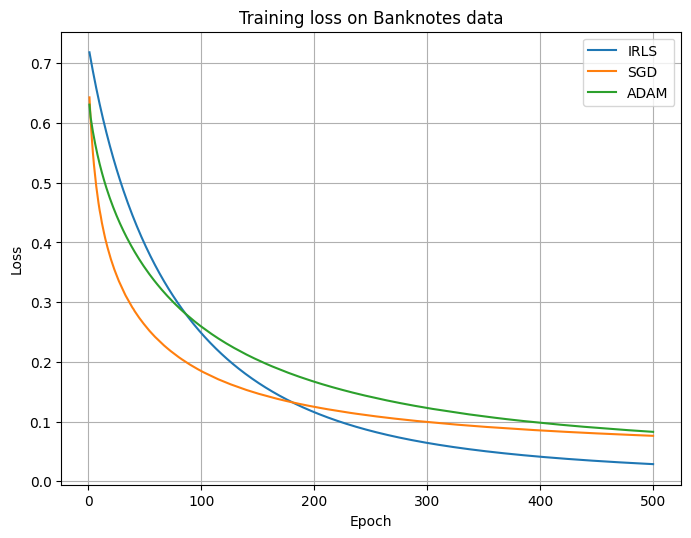

In [16]:
plot_convergence(
    results_banknotes_ours, 
    save_name='small_banknotes',
    title='Training loss on Banknotes data',
)

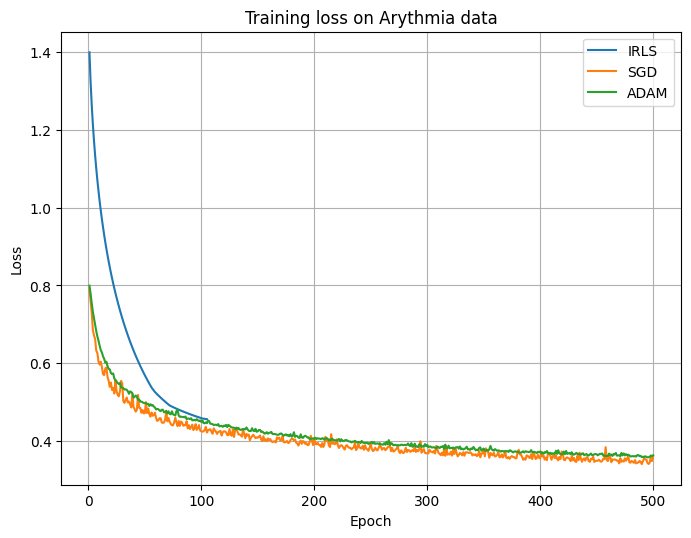

In [17]:
plot_convergence(
    results_arythmia_ours, 
    save_name='large_arythmia',
    title='Training loss on Arythmia data',
)

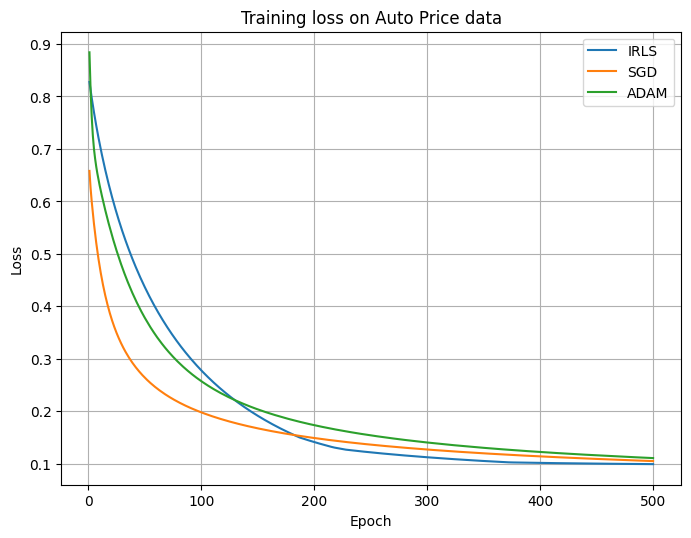

In [18]:
plot_convergence(
    results_auto_ours, 
    save_name='large_auto',
    title='Training loss on Auto Price data',
)

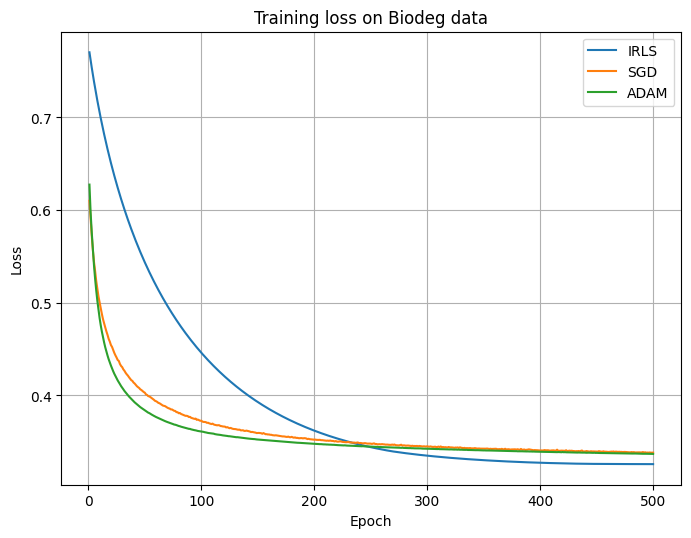

In [19]:
plot_convergence(
    results_biodeg_ours,
    save_name='large_biodeg',
    title='Training loss on Biodeg data'
)

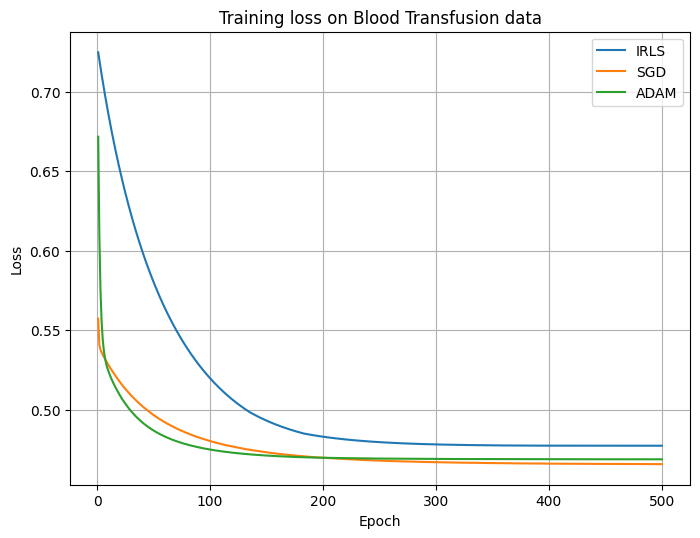

In [20]:
plot_convergence(
    results_blood_ours, 
    save_name='small_blood',
    title='Training loss on Blood Transfusion data',
)

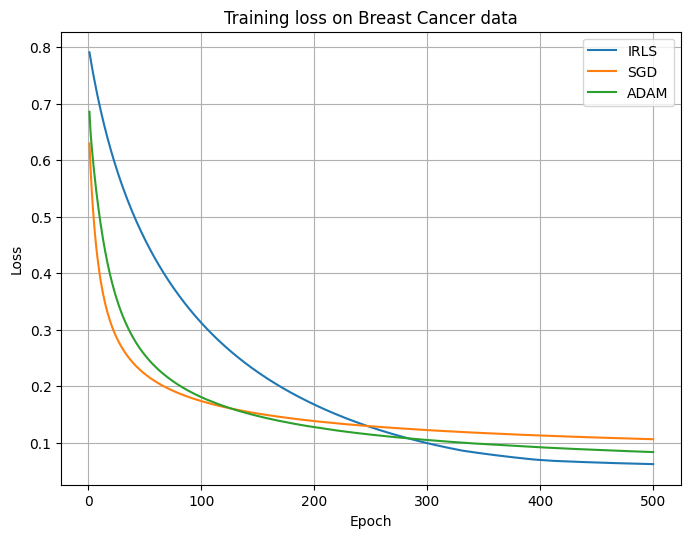

In [21]:
plot_convergence(
    results_breast_ours, 
    save_name='large_breast',
    title='Training loss on Breast Cancer data',
)

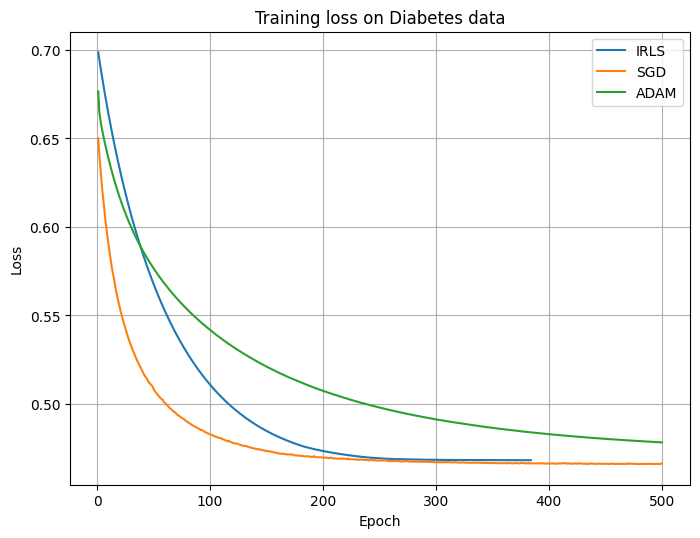

In [22]:
plot_convergence(
    results_diabetes_ours, 
    save_name='small_diabetes',
    title='Training loss on Diabetes data',
)

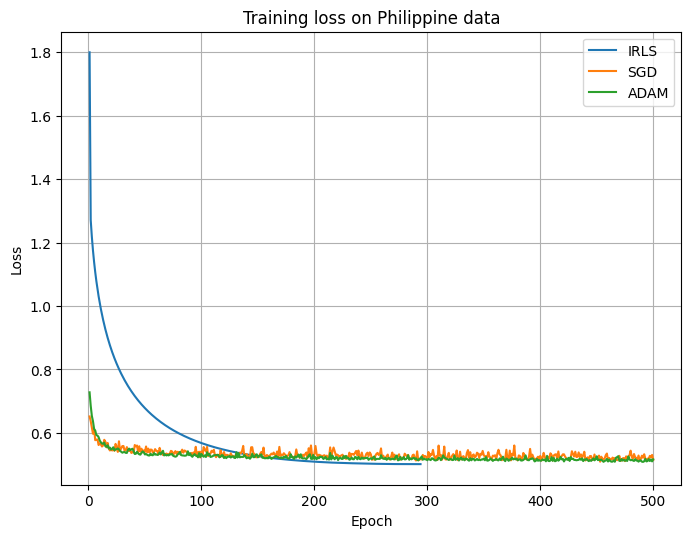

In [23]:
plot_convergence(
    results_philippine_ours, 
    save_name='large_philippine',
    title='Training loss on Philippine data',
)

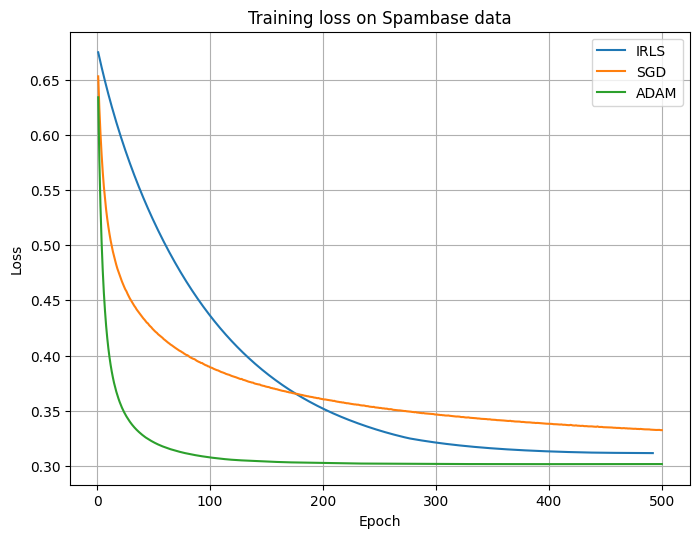

In [24]:
plot_convergence(
    results_spambase_ours, 
    save_name='large_spambase',
    title='Training loss on Spambase data',
)

## Comparison of classification performance

In [25]:
def compare_classification_performance(results_ours: dict, results_other: dict, 
                                       title: Optional[str] = None, 
                                       save_name: Optional[str] = None):
    # filter out results for algorithms with interactions
    results_ours_no_int = {k: v for k, v in results_ours.items() if not k.endswith('+INT')}

    results_df = pd.DataFrame(columns=['algorithm', 'bal_acc', 'is_ours'])

    for alg_name, results_dict in results_ours_no_int.items():
        results_df.loc[len(results_df.index)] = [alg_name, results_dict['final_score'], True]

    for alg_name, bal_acc in results_other.items():
        results_df.loc[len(results_df.index)] = [alg_name, bal_acc, False]

    results_df = results_df\
        .sort_values('bal_acc', ascending=False)\
        .reset_index(drop=True)
    results_ours = results_df[results_df['is_ours']]
    results_other = results_df[~results_df['is_ours']]
    
    plt.figure(figsize=(8, 6), dpi=100)
    cmap = plt.get_cmap("tab10")
    plt.bar(
        results_ours.index,
        results_ours['bal_acc'],
        color=cmap(0),
        label='Our algorithm',
    )
    plt.bar(
        results_other.index,
        results_other['bal_acc'],
        color=cmap(1),
        label='Other',
    )
    plt.xlabel('Algorithm')
    plt.ylabel('Balanced Accuracy')
    plt.xticks(
        ticks=results_df.index,
        labels=results_df['algorithm'],
        rotation=45,
    )
    plt.ylim([0, 1.15])  # make space for a legend
    plt.grid(axis='y')
    plt.legend()

    if save_name is not None:
        plt.savefig(f'plots/comparison_{save_name}.png')

    if title is not None:
        plt.title(title)

    plt.show()

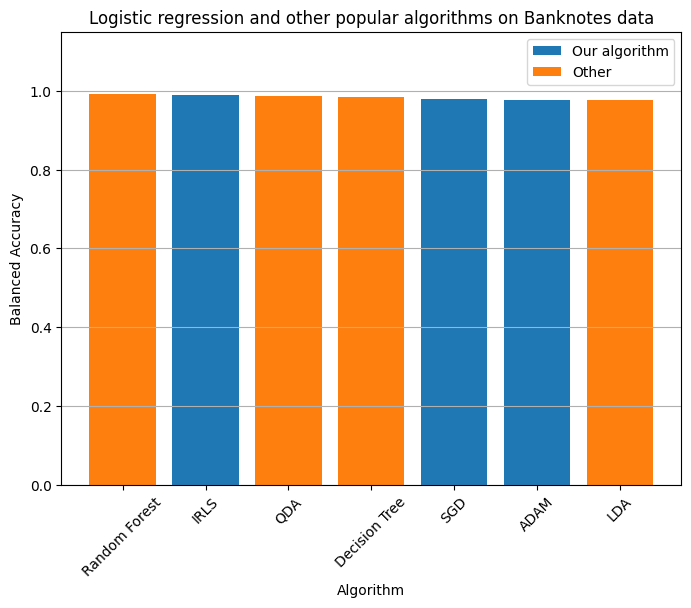

In [26]:
compare_classification_performance(
    results_banknotes_ours, 
    results_banknotes_other,
    save_name='small_banknotes',
    title='Logistic regression and other popular algorithms on Banknotes data',
)

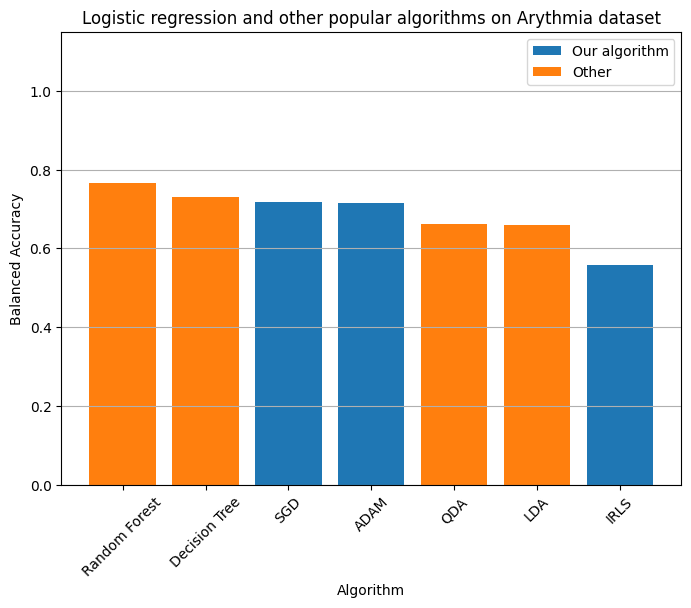

In [27]:
compare_classification_performance(
    results_arythmia_ours, 
    results_arythmia_other,
    save_name='large_arythmia',
    title='Logistic regression and other popular algorithms on Arythmia dataset',
)

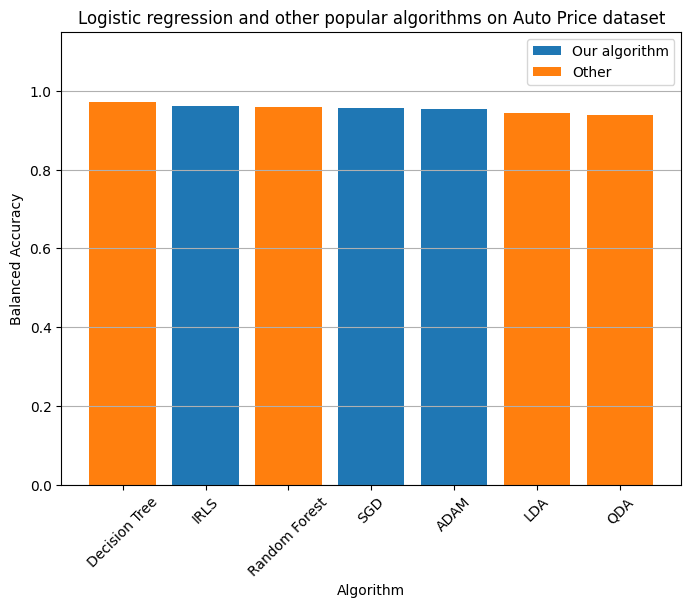

In [28]:
compare_classification_performance(
    results_auto_ours, 
    results_auto_other,
    save_name='large_auto',
    title='Logistic regression and other popular algorithms on Auto Price dataset',
)

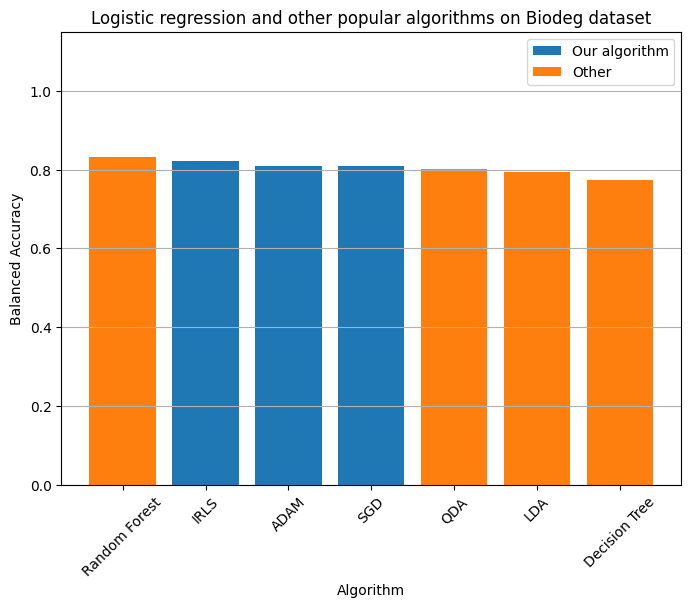

In [29]:
compare_classification_performance(
    results_biodeg_ours, 
    results_biodeg_other,
    save_name='large_biodeg',
    title='Logistic regression and other popular algorithms on Biodeg dataset',
)

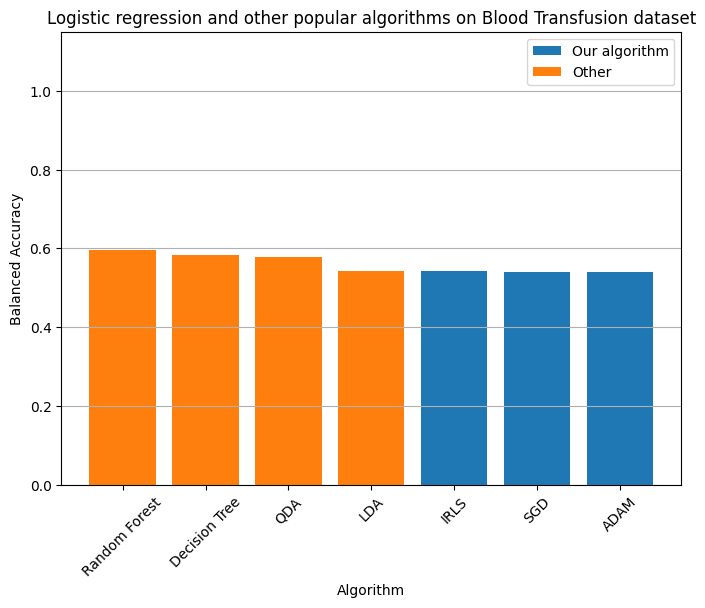

In [30]:
compare_classification_performance(
    results_blood_ours, 
    results_blood_other,
    save_name='small_blood',
    title='Logistic regression and other popular algorithms on Blood Transfusion dataset',
)

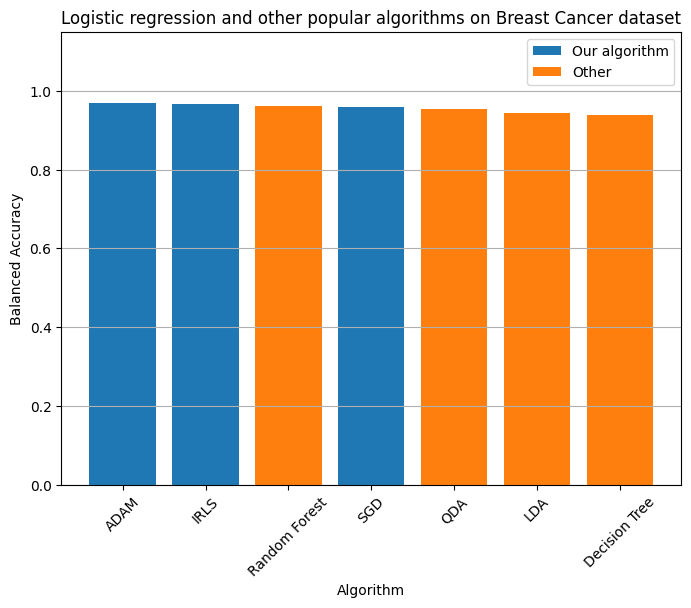

In [31]:
compare_classification_performance(
    results_breast_ours, 
    results_breast_other,
    save_name='large_breast',
    title='Logistic regression and other popular algorithms on Breast Cancer dataset',
)

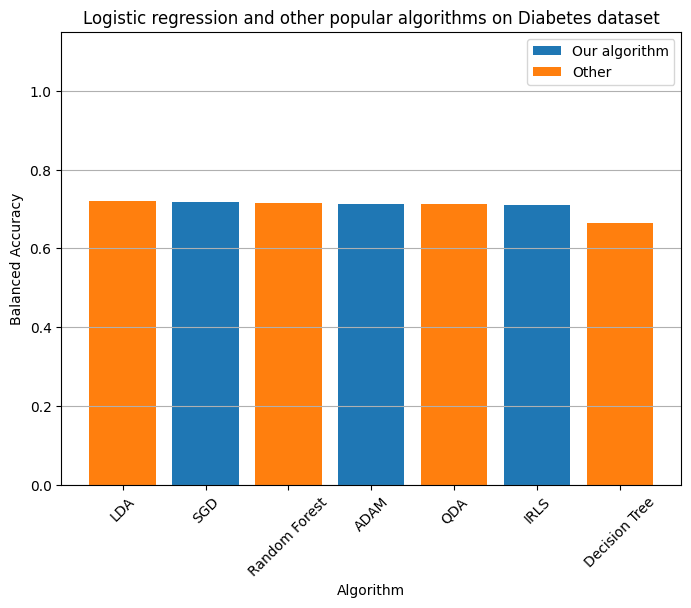

In [32]:
compare_classification_performance(
    results_diabetes_ours, 
    results_diabetes_other,
    save_name='small_diabetes',
    title='Logistic regression and other popular algorithms on Diabetes dataset',
)

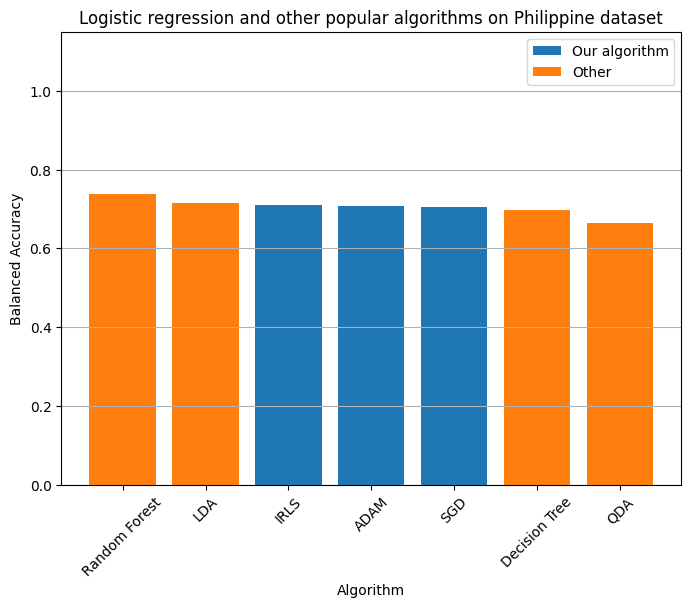

In [33]:
compare_classification_performance(
    results_philippine_ours, 
    results_philippine_other,
    save_name='large_philippine',
    title='Logistic regression and other popular algorithms on Philippine dataset',
)

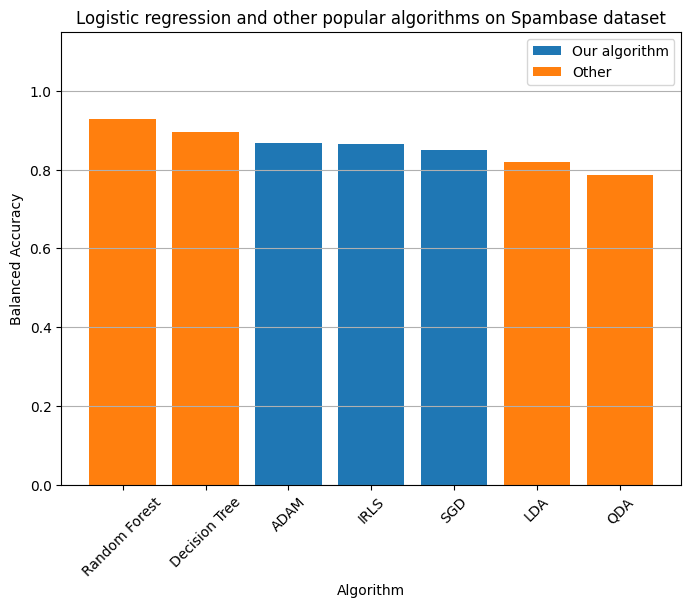

In [34]:
compare_classification_performance(
    results_spambase_ours, 
    results_spambase_other,
    save_name='large_spambase',
    title='Logistic regression and other popular algorithms on Spambase dataset',
)

## Comparison of classification performance of models with and without interactions

In [35]:
def compare_interactions(results_ours: dict, 
                         title: Optional[str] = None, 
                         save_name: Optional[str] = None):
    alg_base_names = [alg_name for alg_name in results_ours.keys() if not alg_name.endswith('+INT')]

    result_df = pd.DataFrame(columns=['Algorithm', 'Balanced Accuracy', 'Interactions'])

    for alg_base_name in alg_base_names:
        bal_acc_regular = results_ours[alg_base_name]['final_score']
        bal_acc_interactions = results_ours[f'{alg_base_name}+INT']['final_score']
        result_df.loc[len(result_df.index)] = [alg_base_name, bal_acc_regular, 'No interactions']
        result_df.loc[len(result_df.index)] = [alg_base_name, bal_acc_interactions, 'Uses interactions']
    
    plt.figure(figsize=(8, 6), dpi=100)
    sns.barplot(
        data=result_df,
        x='Algorithm',
        y='Balanced Accuracy',
        hue='Interactions',
    )
    plt.ylim([0, 1.15])  # make space for a legend
    plt.grid(axis='y')
    plt.legend()

    if save_name is not None:
        plt.savefig(f'plots/interactions_{save_name}.png')

    if title is not None:
        plt.title(title)
    
    plt.show()

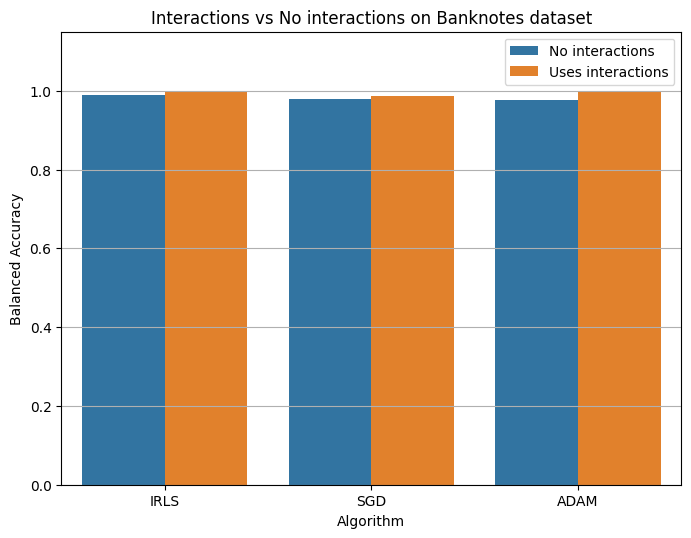

In [36]:
compare_interactions(
    results_banknotes_ours, 
    save_name='banknotes',
    title='Interactions vs No interactions on Banknotes dataset'
)

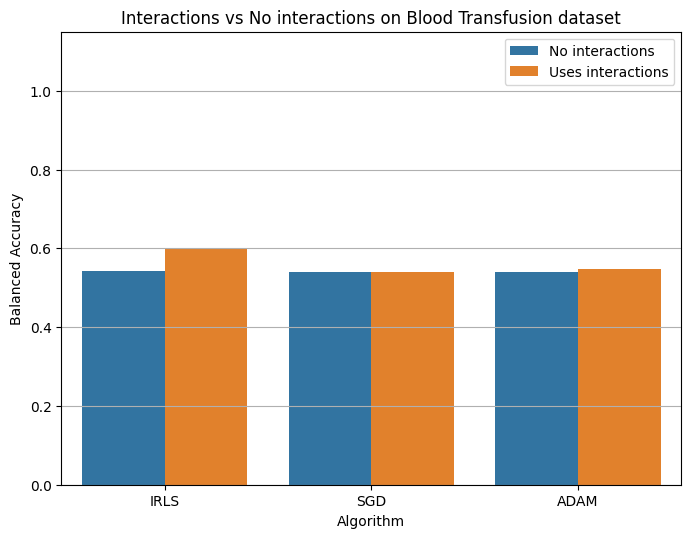

In [37]:
compare_interactions(
    results_blood_ours, 
    save_name='blood',
    title='Interactions vs No interactions on Blood Transfusion dataset'
)

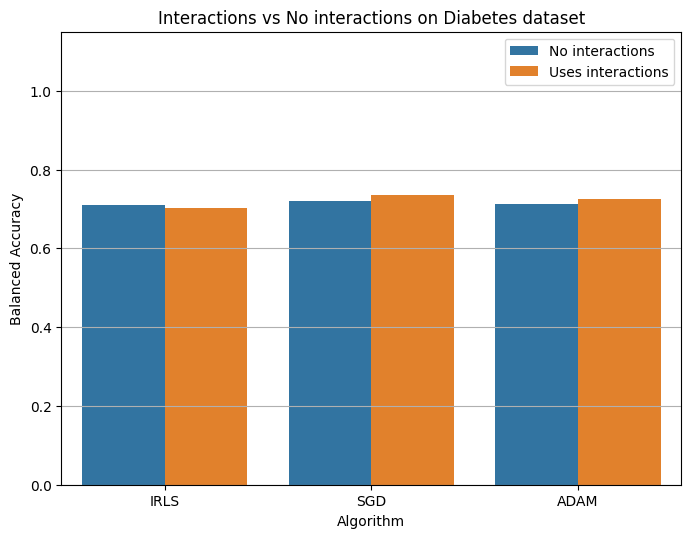

In [38]:
compare_interactions(
    results_diabetes_ours, 
    save_name='diabetes',
    title='Interactions vs No interactions on Diabetes dataset'
)

Analysis of the results is placed in the report